<a href="https://colab.research.google.com/github/zsombor-haasz/computer-vision/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Conditional GANs

In this section, we will be creating a conditional GAN, one of the earlier models used for image generation conditioned on a label which contains everything we want to be in the resulting generated image. We will be doing so on the Celebs A dataset, which is a very low complexity dataset for our models to learn from, providing good results with less work.

Your objective will be to define the training loop for a small conditional GAN setup. The model will be generating conditioned on a label corresponding to the face that indicates it as either "male" or "female".

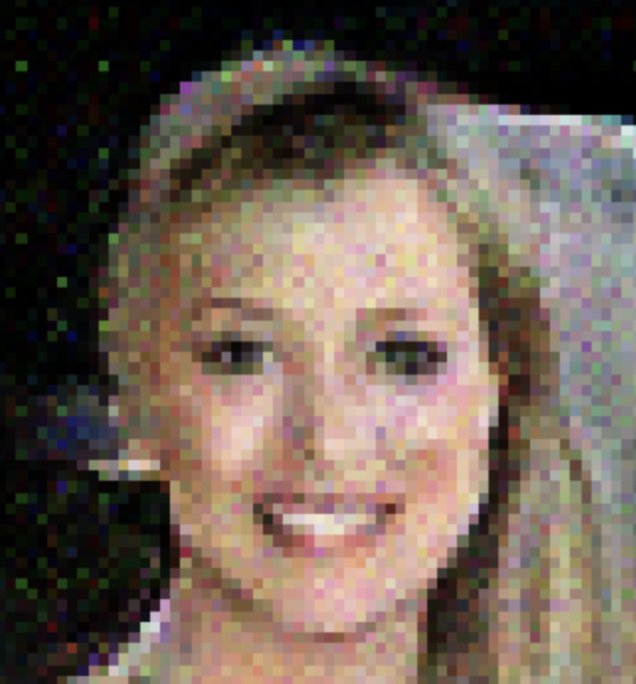

### Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets
from torchvision.datasets import VisionDataset
from torchsummary import summary

from tqdm.notebook import tqdm

%load_ext autoreload

%autoreload 2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)


Mounted at /content/gdrive


This cell takes a minute or two to run (downloading and unzipping takes a minute). Running this cell more than once will error

In [ ]:
%%bash

# Makes directory in google drive for this class's checkpoints
mkdir "/content/gdrive/My Drive/IntroCVHomeworks/"
mkdir "/content/gdrive/My Drive/IntroCVHomeworks/HW3/"
mkdir "/content/gdrive/My Drive/IntroCVHomeworks/HW3/checkpoints"


# Downloading
gdown --folder https://drive.google.com/drive/folders/18yE0tUnb7JkHv_zTcQl-9q1ufNDJhtu6?usp=sharing

# Moving stuff
mkdir celeba
mv CelebA/Anno/identity_CelebA.txt celeba
mv CelebA/Anno/list_attr_celeba.txt celeba
mv CelebA/Anno/list_bbox_celeba.txt celeba
mv CelebA/Anno/list_landmarks_align_celeba.txt celeba
mv CelebA/Anno/list_landmarks_celeba.txt celeba

mv CelebA/Eval/list_eval_partition.txt celeba

mv CelebA/Img/img_align_celeba.zip celeba

# Unzipping dataset
unzip celeba/img_align_celeba.zip -d celeba

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

mkdir: cannot create directory ‘/content/gdrive/My Drive/IntroCVHomeworks/’: File exists
mkdir: cannot create directory ‘/content/gdrive/My Drive/IntroCVHomeworks/HW3/’: File exists
mkdir: cannot create directory ‘/content/gdrive/My Drive/IntroCVHomeworks/HW3/checkpoints’: File exists
Retrieving folder list
Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1Q29CkVI7yuOHb_VV1nF1LUkCE0U_Kd9c
To: /content/CelebA/Anno/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 29.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WvmQY6Ag4tab5cGSZ3S2KaNfSg2EiBaS
To: /content/CelebA/Anno/list_a

# Dataset Exploration

In [ ]:
ds = torchvision.datasets.CelebA('.', split='train')


In [ ]:
with open('./celeba/list_attr_celeba.txt') as file:
  attr_names = file.read().split('\n')[1].split()
for name in attr_names:
  print(name)

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [ ]:
def read_label(label: torch.tensor):
  with open('./celeba/list_attr_celeba.txt') as file:
    attr_names = file.read().split('\n')[1].split()
  assert len(label.shape) <= 2
  if len(label.shape) == 2:
    for i, l in enumerate(label):
      print("Label " + str(i) + "-------------")
      for idx in torch.where(l)[0]:
        print(idx)
        print(attr_names[idx.item()])
  else:
    for idx in torch.where(label)[0]:
      print(attr_names[idx.item()])



Picture in the dataset with the label

In [ ]:
ds[2][1]

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1])

In [ ]:
read_label(ds[2][1])

Big_Lips
Blurry
Male
Narrow_Eyes
No_Beard
Pointy_Nose
Wavy_Hair
Young


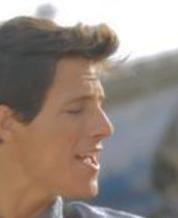

In [ ]:
ds[2][0]

# CGAN Architecture

In [ ]:
assert torch.cuda.is_available(), "Make sure you are on a GPU. Please select \"runtime\" and then \"change runtime type\""

device = torch.device("cuda:0")


In [ ]:
import os, time, sys
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# G(z)
class GeneratorSmall(nn.Module):
    # initializers
    def __init__(self, classes, d=128, latent_size=128):
        super(GeneratorSmall, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(latent_size, d*4, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*4)
        self.deconv1_2 = nn.ConvTranspose2d(classes, d*4, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        # self.deconv4 = nn.ConvTranspose2d(d, 3, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    # def forward(self, input):
    def forward(self, input, label):
        """
        Expects an input latent vector and a label of the output we want to generate
        """
        x = F.leaky_relu(self.deconv1_1_bn(self.deconv1_1(input)), 0.2)
        y = F.leaky_relu(self.deconv1_2_bn(self.deconv1_2(label)), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        # x = F.tanh(self.deconv4(x))
        x = F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x = F.sigmoid(self.deconv5(x))

        return x

class DiscriminatorSmall(nn.Module):
    # initializers
    def __init__(self, classes, d=128):
        super(DiscriminatorSmall, self).__init__()
        self.conv1_1 = nn.Conv2d(3, int(d/2), 4, 2, 1)
        self.conv1_2 = nn.Conv2d(classes, int(d/2), 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        # self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    # def forward(self, input):
    def forward(self, input, label):
        """
        Takes in an input image and a conditional label and decides how real it looks
        """
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        # x = F.sigmoid(self.conv4(x))
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x


In [ ]:
modelG = GeneratorSmall(10).to(device)
summary(modelG, [(128, 1, 1), (10, 1, 1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,049,088
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
   ConvTranspose2d-3            [-1, 512, 4, 4]          82,432
       BatchNorm2d-4            [-1, 512, 4, 4]           1,024
   ConvTranspose2d-5            [-1, 512, 8, 8]       8,389,120
       BatchNorm2d-6            [-1, 512, 8, 8]           1,024
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,408
       BatchNorm2d-8          [-1, 256, 16, 16]             512
   ConvTranspose2d-9          [-1, 128, 32, 32]         524,416
      BatchNorm2d-10          [-1, 128, 32, 32]             256
  ConvTranspose2d-11            [-1, 3, 64, 64]           6,147
Total params: 12,152,451
Trainable params: 12,152,451
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
modelD = DiscriminatorSmall(10).to(device)
summary(modelD, [(3, 64, 64), (10, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
            Conv2d-2           [-1, 64, 32, 32]          10,304
            Conv2d-3          [-1, 256, 16, 16]         524,544
       BatchNorm2d-4          [-1, 256, 16, 16]             512
            Conv2d-5            [-1, 512, 8, 8]       2,097,664
       BatchNorm2d-6            [-1, 512, 8, 8]           1,024
            Conv2d-7           [-1, 1024, 4, 4]       8,389,632
       BatchNorm2d-8           [-1, 1024, 4, 4]           2,048
            Conv2d-9              [-1, 1, 1, 1]          16,385
Total params: 11,045,249
Trainable params: 11,045,249
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1920.00
Forward/backward pass size (MB): 2.75
Params size (MB): 42.13
Estimated Total Size (MB): 1964.88
------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


#TODO: Train Loop Function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols, figsize = (40, 40))
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow((images[title][0].swapaxes(0, -1).swapaxes(0, 1) + 1) / 2)
        ax.ravel()[ind].set_title(title + ' ' + str(images[title][1]))
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()


def training_loop(dataloader, label_size, latent_size, b_size, img_size, epochs, generator, discriminator, optimizerG, optimizerD, show_after_epoch = True,
                  checkpoint_directory = "/content/gdrive/My Drive/IntroCVHomeworks/HW3/checkpoints/", exp_name = None, gen_steps = 2,
                  disc_steps = 1, epoch_start = 0, max_train_steps_per_epoch = -1):

    criterion = nn.BCELoss()
    generator_history = []
    discriminator_history = []
    batch_size = b_size
    #Actual training loop
    for epoch in range(epoch_start, epoch_start + epochs):
        batch = tqdm(enumerate(dataloader), desc = "Epoch " + str(epoch), total = (min(len(ds)//b_size, max_train_steps_per_epoch) if max_train_steps_per_epoch > 0 else len(ds)//b_size))

        #not sure what this is, but evan had it in his code
        if epoch == 5 or epoch == 10:
            optimizerG.param_groups[0]['lr'] /= 10
            optimizerD.param_groups[0]['lr'] /= 10

        for i, (images, labels) in batch:
            if max_train_steps_per_epoch != -1 and i >= max_train_steps_per_epoch:
                break
            #Setup stuffs ---------------
            images = images.to(device)

            batch_size = images.shape[0]
            """
            TODO:
            We need target labels to feed into our classification loss.
            We need a tensor of shape (batch_size,) of ones and another tensor
            of the same shape but filled with zeros. You should consider using
            torch.ones and torch.zeros for this

            This is because the discriminator wants target values of all 1's on real images
            and target values of all 0's on fake images, so we need to use these as our targets
            in our classification loss later on
            """
            y_real = _________.to(device).to(torch.float).squeeze() # Classify real images as 1
            y_fake = _________.to(device).to(torch.float).squeeze() # Classify fake images as 0



            # These are the true conditional labels for this batch of data and we
            # will be using these labels for both our generator and discriminator
            # These are the same numbers, just different shapes since our generator and discriminator
            # expect these specific shapes as input
            g_labels = labels.unsqueeze(-1).unsqueeze(-1).to(device)
            d_labels = g_labels.broadcast_to((batch_size, label_size, img_size, img_size))


            #----------------------------

            #Discriminator training
            disc_losses = []
            disc_accuracies = []
            for i in range(disc_steps):
                # TODO: Zero the discriminator gradients

                #get the loss on real images (and metrics)
                """
                TODO:
                1. Call the discriminator on the images we got at the start of this train step and the
                conditional labels we made specifically for our descriminator (d_labels)
                  - As a note, you can go look at our discriminator's forward() function if you want to
                    see that our forward() function takes in multiple args
                2. Call our loss (criterion) on our discriminator's output on real images and the target (y)
                values for real images that you defined earlier
                """
                D_out_real = discriminator(_<image>__, __<conditional label>__).squeeze()
                D_loss_real = criterion(___<disc outputs>____, ___<y label for real images>___)
                real_accuracy = torch.mean(1 - torch.abs(D_out_real - y_real)).item()

                #get the loss on fake images (and metrics)
                """
                TODO:
                1. Make a gaussian random noise vector of size (batch_size, latent_size, 1, 1)
                2. Feed this noise (our latent vector) and conditional labels we made specifically for our generator
                into the generator
                """
                noise = _______.to(device)
                gen_image = generator(___<latent>____, ___<conditional label for fake images>___)

                """
                TODO:
                1. Call discriminator on the generated images and the discriminator labels we made
                2. Call our loss function on discriminators outputs and target labels (y) of fake
                """
                D_out_fake = discriminator(____, ____).squeeze()
                D_loss_fake = criterion(_____, _____)
                fake_accuracy = torch.mean(1 - torch.abs(D_out_fake - y_fake)).item()

                #TODO: add real and fake losses and backprop and step the discriminator's optimizer
                D_loss = _____
                __________
                __________

                #recording for metrics
                disc_losses.append(D_loss.item())
                disc_accuracies.append((real_accuracy, fake_accuracy))

            #Generator training
            gen_losses = []
            for i in range(gen_steps):
                generator.zero_grad()

                #get discriminator predictions on faked images, and take loss between real y
                """
                TODO:
                1. Create another noise vector of the same shape (batch_size, latent_size, 1, 1)
                2. Pass this and the generator's conditional labels into the generator
                """
                noise = __________.to(device)
                gen_image = generator(______, ______)

                """
                TODO:
                1. Pass generated image and discriminator's conditional labels into discriminator
                2. Get the classification loss on discriminators output and REAL target (y) value
                  - The reason for these being labeled as "real" is we are doing the non-saturating loss which amounts to
                    the generator wanting to get our labels to be equal to 1 on the same binary cross entropy loss.
                  - This gradient here will only effect the generator, hence why we can do this
                """
                D_out_gen = discriminator(_____, ____).squeeze()
                gen_loss = criterion(____, _____)

                #TODO: backprop and step the generator's optimizer
                ________
                ________

                gen_losses.append(gen_loss.item())

            batch.set_postfix({'Disc loss': torch.mean(torch.tensor(disc_losses[-disc_steps:])).item(),
                  'Gen loss': torch.mean(torch.tensor(gen_losses[-disc_steps:])).item(),
                  'Disc Real Accuracy': torch.mean(torch.tensor([disc_accuracies[-i-1][0] for i in range(disc_steps)])).item(),
                  'Disc Fake Accuracy': torch.mean(torch.tensor([disc_accuracies[-i-1][1] for i in range(disc_steps)])).item()})

            #append losses to the histories
            generator_history.append(gen_losses)
            discriminator_history.append(disc_losses)

        #printing some outputs
        if show_after_epoch:
            _, labels = next(iter(dataloader))
            g_labels = labels.unsqueeze(-1).unsqueeze(-1).to(device)
            noise = torch.randn(b_size, latent_size, device = device).view(-1, latent_size, 1, 1)
            gen_image = generator(noise, g_labels)
            images = [gen_image[i].squeeze().to('cpu').detach() for i in range(min(b_size, 8))]
            labels = [labels[i].squeeze().to('cpu').detach() for i in range(min(b_size, 8))]
            images = {'Image'+str(i): [image.numpy(), label.numpy()] for i, (image, label) in enumerate(zip(images, labels))}
            display_multiple_img(images, min(b_size, 8), 1)

        #checkpointing the GAN
        if checkpoint_directory:
            if not exp_name:
                exp_name = 'unnamed'
            torch.save({
                        'generator_losses': generator_history,
                        'discriminator_losses': discriminator_history,
                        'epoch': epoch,
                        'generator_state_dict': generator.state_dict(),
                        'discriminator_state_dict': discriminator.state_dict(),
                        'generator_optimizer_state_dict': optimizerG.state_dict(),
                        'discriminator_optimizer_state_dict': optimizerD.state_dict(),
                        }, checkpoint_directory + '/' + exp_name + '_' + str(epoch) + '.pt')


    return generator_history, discriminator_history



In [ ]:
#train loop
import torch.optim as optim

#define the variables in here #-------------


# Training hyperparameters you can feel free to play around with
_bsize = 128
_gen_steps = 1
_disc_steps = 3
_epochs = 20



def label_transform_fn(attrs_desired):
    """
    This function takes in a list of strings that are attributes listed in our dataset exploration
    section and returns a transform for our label. It also returns the label size

    Our dataset has 40 different attributes, but maybe we only care about controlling
    2 or 3 of them. Instead of passing in the label vector for all 40 attributes to our models,
    this transform will cut down our label so it only includes the attributes in the label we
    care about in the order specified by our input attrs_desired
    """
    with open('./celeba/list_attr_celeba.txt') as file:
        attr_names = file.read().split('\n')[1].split()

    idxs = [attr_names.index(attr) for attr in attrs_desired]

    print("Conditioning on the following attributes:")
    for i in idxs:
        print(attr_names[i])
    print("-----------------------------------------")

    return lambda x: x[idxs].float(), len(attrs_desired)



# For us, we will only condition on male vs female, so of our attribute names, this is the only ones we care about
# This will make our label [1,] if male and [0,] if female. Feel free to play with this if you want
# to condition on more than one label and control other things too
target_transform, label_size = label_transform_fn(["Male"])

checkpoint_path = path = '/content/gdrive/My Drive/IntroCVHomeworks/HW3/checkpoints/'
_img_size = 64
latent_size = 128
#-------------------------------------------------------

generator = GeneratorSmall(classes=label_size, latent_size=latent_size).to(device)
discriminator = DiscriminatorSmall(classes=label_size).to(device)

_lr = 0.0002
betas = (.5, 0.999)

# TODO: Please initialize an Adam optimizer running standard gradient descent using
# the above learning rate and betas for BOTH the generator and discriminator separately
# This is the same thing you've seen to create optimizers for networks before,
# only now we want to have a separate generator optimizer and discriminator optimizer
# containing the generator's params and discriminator's params separately. Go to
# torch's documentation for optim.Adam if you want a hint
optimizerG =
optimizerD =

#---------------------------------------------------------------


ds = torchvision.datasets.CelebA('.',
                                 split='train',
                                 transform=torchvision.transforms.Compose([torchvision.transforms.PILToTensor(),
                                                                                               torchvision.transforms.Resize((_img_size, _img_size)),
                                                                                               lambda x: x / 256]),
                                 target_transform = target_transform)

dataloader = DataLoader(ds, batch_size=_bsize, shuffle=True)


Conditioning on the following attributes:
Male
-----------------------------------------


In [ ]:
training_loop(dataloader, label_size, latent_size, _bsize, _img_size, _epochs, generator, discriminator, optimizerG, optimizerD, True,
                  checkpoint_path, None, _gen_steps, _disc_steps, epoch_start = 0, max_train_steps_per_epoch=500)

# Eval

This section is semi-broken, but don't worry about it, it's some code to get you started if you want to reload one of the checkpoints we have saaved

In [ ]:
#These are the things that you should edit
path = '/content/gdrive/My Drive/IntroCVHomeworks/HW3/checkpoints/'
label_size = 40
generator = GeneratorSmall(classes=label_size)


#double list of all the labels you want
labels = [[0, 1] for i in range(16)]


#----------------------


def display_final(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols, figsize = (40, 40))
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow((images[title][0].swapaxes(0, -1).swapaxes(0, 1) + 1) / 2)
        ax.ravel()[ind].set_title(title + ' ' + str(images[title][1]))
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

bs = len(labels)
generator.load_state_dict(torch.load(path)['generator_state_dict'])
generator.eval()

labels = torch.tensor(labels).unsqueeze(-1).unsqueeze(-1).float()
noise = torch.randn(bs, 100, 1, 1)
gen_image = generator(noise, labels)


images = [gen_image[i].squeeze().to('cpu').detach() for i in range(bs)]
labels = [labels[i].squeeze().to('cpu').detach() for i in range(bs)]
images = {'Image'+str(i): [image.numpy(), label.numpy()] for i, (image, label) in enumerate(zip(images, labels))}

display_final(images, 4, 4)
